In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import quality_metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
from scipy import stats
from math import sqrt

In [70]:
data = pd.read_csv("../data/cars_processed.csv")

In [71]:
y = data['price_usd']
X = data.drop('price_usd', axis=1)

In [72]:
y

0        10900
1         2134
2         4500
3        12900
4         4200
         ...  
29388     3700
29389     3450
29390     6500
29391     2800
29392     2700
Name: price_usd, Length: 29393, dtype: int64

In [73]:
X

,manufacturer_name,model_name,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_capacity,body_type,has_warranty,...,transmission_automatic,transmission_mechanical,engine_type_diesel,engine_type_gasoline,state_emergency,state_new,state_owned,drivetrain_all,drivetrain_front,drivetrain_rear
0,45,763,8,190000,2010,2,0,2.5,10,0,...,1,0,0,1,0,0,1,1,0,0
1,45,664,0,280000,2001,2,0,2.5,10,0,...,1,0,0,1,0,0,1,1,0,0
2,45,664,8,350000,2004,2,0,2.5,8,0,...,1,0,0,1,0,0,1,1,0,0
3,45,763,4,179000,2010,2,0,2.5,10,0,...,1,0,0,1,0,0,1,1,0,0
4,45,519,8,571317,1999,2,0,2.5,10,0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29388,8,1057,7,300000,2002,1,1,2.4,6,0,...,1,0,0,1,0,0,1,0,1,0
29389,8,582,4,179000,1998,2,0,3.3,6,0,...,1,0,0,1,0,0,1,0,1,0
29390,8,1057,8,240000,2005,0,0,2.5,6,0,...,0,1,1,0,0,0,1,0,1,0
29391,8,765,1,177000,2003,2,0,2.4,8,0,...,1,0,0,1,0,0,1,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((23514, 26), (23514,), (5879, 26), (5879,))

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
def print_metrics(X_test, y_pred, model):
    print(f'MAE: {round(mean_absolute_error(y_test, y_pred), 4)}')
    print(f'MSE: {round(mean_squared_error(y_test, y_pred), 4)}')
    print(f'RMSE: {round(sqrt(mean_squared_error(y_test, y_pred)), 4)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 4)}')
    print(f'R^2: {round(model.score(X_test, y_test), 2)}')


def print_weights(model):
    print(f"\nb0: {model.intercept_}")
    print(model.coef_)

<font size = 6>
    <b>Простая линейная регрессия</b>
</font>

Выберем признак, который лучше всего связан с целевым признаком с помощью корреляции Пирсона

In [ ]:
col_list = X.columns.to_list()
pearson, p_values = [], []
for column in col_list:
    pearson_coef, p_value = stats.pearsonr(data[column], y)
    pearson.append(pearson_coef)
    p_values.append(round(p_value, 3))
df = pd.DataFrame({'column': col_list, 'coef': pearson, 'p': p_values})
df

,column,coef,p
0,manufacturer_name,-0.004445,0.446
1,model_name,0.143407,0.000
2,color,-0.049954,0.000
3,odometer_value,-0.409295,0.000
4,year_produced,0.784130,0.000
5,engine_fuel,-0.098463,0.000
6,engine_has_gas,-0.076430,0.000
7,engine_capacity,0.162286,0.000
8,body_type,0.159353,0.000
9,has_warranty,0.192075,0.000


In [ ]:
df[df.coef == df.coef.max()]

,column,coef,p
4,year_produced,0.78413,0.0


In [ ]:
X_slr_train, X_slr_test = X_train[['year_produced']], X_test[['year_produced']]

In [ ]:
slr = LinearRegression().fit(X_slr_train, y_train)
y_pred = slr.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, slr)
print_weights(slr)

MAE: 1988.7845
MSE: 7280325.8783
RMSE: 2698.2079
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.90786412]


In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1)}
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
lasso_optimal = GridSearchCV(Lasso(), parameters).fit(X_slr_train, y_train)
y_pred = lasso_optimal.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, lasso_optimal)
print_weights(lasso_optimal.best_estimator_)
lasso_optimal.best_params_

MAE: 1988.7793
MSE: 7280340.1242
RMSE: 2698.2105
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3312.90786412]


{'alpha': np.float64(1.0)}

In [ ]:
lasso_optimal = RandomizedSearchCV(Lasso(), parameters).fit(X_slr_train, y_train)
y_pred = lasso_optimal.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, lasso_optimal)
print_weights(lasso_optimal.best_estimator_)
lasso_optimal.best_params_

MAE: 1988.7798
MSE: 7280338.6065
RMSE: 2698.2103
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.00786412]


{'alpha': np.float64(0.9)}

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    model = Lasso(alpha=alpha)
    model.fit(X_slr_train, y_train)
    y_pred = model.predict(X_slr_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = Lasso(alpha=best_params['alpha'])
best_model.fit(X_slr_train, y_train)

y_pred = best_model.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, best_model)
print_weights(best_model)
best_params

MAE: 1988.7845
MSE: 7280325.8783
RMSE: 2698.2079
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.90786412]


{'alpha': 0.0}

In [ ]:
ridge_optimal = GridSearchCV(Ridge(), parameters).fit(X_slr_train, y_train)
y_pred = ridge_optimal.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, ridge_optimal)
print_weights(ridge_optimal.best_estimator_)
ridge_optimal.best_params_

MAE: 1988.7838
MSE: 7280327.7606
RMSE: 2698.2083
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.76693671]


{'alpha': np.float64(1.0)}

In [ ]:
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_slr_train, y_train)
y_pred = ridge_optimal.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, ridge_optimal)
print_weights(ridge_optimal.best_estimator_)
ridge_optimal.best_params_

MAE: 1988.7838
MSE: 7280327.7606
RMSE: 2698.2083
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.76693671]


{'alpha': np.float64(1.0)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    model = Ridge(alpha=alpha)
    model.fit(X_slr_train, y_train)
    y_pred = model.predict(X_slr_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = Ridge(alpha=best_params['alpha'])
best_model.fit(X_slr_train, y_train)

y_pred = best_model.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, best_model)
print_weights(best_model)
best_params

MAE: 1988.7845
MSE: 7280325.8783
RMSE: 2698.2079
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.90786412]


{'alpha': 0.0}

In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1),
              'l1_ratio': np.arange(0, 1.1, 0.1)}

In [ ]:
elastic_optimal = GridSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_slr_train, y_train)
y_pred = elastic_optimal.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, elastic_optimal)
print_weights(elastic_optimal.best_estimator_)
elastic_optimal.best_params_

MAE: 1988.7793
MSE: 7280340.1242
RMSE: 2698.2105
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3312.90786412]


{'alpha': np.float64(1.0), 'l1_ratio': np.float64(1.0)}

In [ ]:
elastic_optimal = RandomizedSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_slr_train, y_train)
y_pred = elastic_optimal.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, elastic_optimal)
print_weights(elastic_optimal.best_estimator_)
elastic_optimal.best_params_

MAE: 1988.7814
MSE: 7280334.1775
RMSE: 2698.2094
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.30786412]


{'l1_ratio': np.float64(1.0), 'alpha': np.float64(0.6000000000000001)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1, step=0.1)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_slr_train, y_train)
    y_pred = model.predict(X_slr_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_slr_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
best_slr_model.fit(X_slr_train, y_train)

y_pred = best_slr_model.predict(X_slr_test)
print_metrics(X_slr_test, y_pred, best_slr_model)
print_weights(best_slr_model)
best_params

MAE: 1988.7845
MSE: 7280325.8783
RMSE: 2698.2079
MAPE: 0.8104
R^2: 0.61

b0: 5318.750829293176
[3313.90786412]


{'alpha': 0.0, 'l1_ratio': 0.1}

<font size = 6>
    <b>Множественная линейная регрессия</b>
</font>

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print_metrics(X_test, y_pred, lr)
print_weights(lr)

MAE: 1558.8295
MSE: 4595140.2825
RMSE: 2143.6278
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 118.31391809  104.60779427   32.64297597 -481.69684262 2440.65131525
  596.52769738   69.21763799  420.42745155  121.79689019  135.22570227
  -96.42494575   39.27499435  206.67822178  -68.178021     48.15385636
  931.14049695   94.97206589  -94.97206589  481.0532125  -481.0532125
 -159.83321632  287.95526537  -35.94374593  240.65524306 -272.14606494
  129.79741351]


In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1)}

In [ ]:
lasso_optimal = GridSearchCV(Lasso(), parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = lasso_optimal.predict(X_test)
print_metrics(X_test, y_pred, lasso_optimal)
print_weights(lasso_optimal.best_estimator_)
lasso_optimal.best_params_

MAE: 1558.8295
MSE: 4595140.2825
RMSE: 2143.6278
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 1.18313918e+02  1.04607794e+02  3.26429760e+01 -4.81696843e+02
  2.44065132e+03  5.96527697e+02  6.92176379e+01  4.20427452e+02
  1.21796890e+02  1.35225702e+02 -9.64249458e+01  3.92749943e+01
  2.06678222e+02 -6.81780210e+01  4.81538564e+01  9.31140497e+02
  1.89944132e+02  3.12717032e-11  9.62106425e+02 -1.47959479e-10
 -1.31881785e+02  3.07729299e+02 -1.82181981e+00  2.46497297e+02
 -2.63753342e+02  1.36562768e+02]


{'alpha': np.float64(0.0)}

Сопоставляя признаки, можно заметить, что коэффициенты у признаков 'engine_type_gasoline' и 'transmisssion_mechanical' практически равны 0.

In [ ]:
lasso_optimal = RandomizedSearchCV(Lasso(), parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = lasso_optimal.predict(X_test)
print_metrics(X_test, y_pred, lasso_optimal)
print_weights(lasso_optimal.best_estimator_)
lasso_optimal.best_params_

MAE: 1558.8295
MSE: 4595140.2825
RMSE: 2143.6278
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 1.18313918e+02  1.04607794e+02  3.26429760e+01 -4.81696843e+02
  2.44065132e+03  5.96527697e+02  6.92176379e+01  4.20427452e+02
  1.21796890e+02  1.35225702e+02 -9.64249458e+01  3.92749943e+01
  2.06678222e+02 -6.81780210e+01  4.81538564e+01  9.31140497e+02
  1.89944132e+02  3.12717032e-11  9.62106425e+02 -1.47959479e-10
 -1.31881785e+02  3.07729299e+02 -1.82181981e+00  2.46497297e+02
 -2.63753342e+02  1.36562768e+02]


{'alpha': np.float64(0.0)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
best_model = Lasso(alpha=best_params['alpha'])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print_metrics(X_test, y_pred, best_model)
print_weights(best_model)
best_params

MAE: 1558.4661
MSE: 4593970.3274
RMSE: 2143.3549
MAPE: 0.6259
R^2: 0.75

b0: 5318.750829293179
[ 1.17345294e+02  1.04203908e+02  3.17104745e+01 -4.80202016e+02
  2.44114897e+03  4.99349563e+02  4.97978967e+01  4.18859200e+02
  1.21058068e+02  1.34540752e+02 -9.56618604e+01  3.82869136e+01
  2.05419175e+02 -6.67418712e+01  4.67428448e+01  9.31458891e+02
  1.90997070e+02 -0.00000000e+00  8.64548432e+02 -4.14377452e-11
 -1.29446929e+02  3.08340530e+02  0.00000000e+00  1.28405624e+02
 -4.32319536e+02  0.00000000e+00]


{'alpha': 1.0}

Коэффициенты у признаков 'engine_type_gasoline', 'transmisssion_mechanical', 'state_owned' и 'drivetrain_rear' практически равны 0.

In [ ]:
ridge_optimal = GridSearchCV(Ridge(), parameters).fit(X_train, y_train)
y_pred = ridge_optimal.predict(X_test)
print_metrics(X_test, y_pred, ridge_optimal)
print_weights(ridge_optimal.best_estimator_)
ridge_optimal.best_params_

MAE: 1558.82
MSE: 4595107.2536
RMSE: 2143.6201
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 118.30083304  104.62845235   32.64272397 -481.7154679  2440.49078096
  594.47928536   68.82554328  420.355525    121.80253724  135.24647604
  -96.43326595   39.28231064  206.68774777  -68.17257088   48.15448885
  931.17413635   95.01249236  -95.01249236  480.04092397 -480.04092397
 -159.82989154  287.94248434  -35.93906275  240.65678142 -272.13249644
  129.7792528 ]


{'alpha': np.float64(1.0)}

In [ ]:
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_train, y_train)
y_pred = ridge_optimal.predict(X_test)
print_metrics(X_test, y_pred, ridge_optimal)
print_weights(ridge_optimal.best_estimator_)
ridge_optimal.best_params_

MAE: 1558.82
MSE: 4595107.2536
RMSE: 2143.6201
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 118.30083304  104.62845235   32.64272397 -481.7154679  2440.49078096
  594.47928536   68.82554328  420.355525    121.80253724  135.24647604
  -96.43326595   39.28231064  206.68774777  -68.17257088   48.15448885
  931.17413635   95.01249236  -95.01249236  480.04092397 -480.04092397
 -159.82989154  287.94248434  -35.93906275  240.65678142 -272.13249644
  129.7792528 ]


{'alpha': np.float64(1.0)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
best_model = Ridge(alpha=best_params['alpha'])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print_metrics(X_test, y_pred, best_model)
print_weights(best_model)
best_params

MAE: 1558.82
MSE: 4595107.2536
RMSE: 2143.6201
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 118.30083304  104.62845235   32.64272397 -481.7154679  2440.49078096
  594.47928536   68.82554328  420.355525    121.80253724  135.24647604
  -96.43326595   39.28231064  206.68774777  -68.17257088   48.15448885
  931.17413635   95.01249236  -95.01249236  480.04092397 -480.04092397
 -159.82989154  287.94248434  -35.93906275  240.65678142 -272.13249644
  129.7792528 ]


{'alpha': 1.0}

In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1),
              'l1_ratio': np.arange(0, 1.1, 0.1)}

In [ ]:
elastic_optimal = GridSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = elastic_optimal.predict(X_test)
print_metrics(X_test, y_pred, elastic_optimal)
print_weights(elastic_optimal.best_estimator_)
elastic_optimal.best_params_

MAE: 1558.8295
MSE: 4595140.2825
RMSE: 2143.6278
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 1.18313918e+02  1.04607794e+02  3.26429760e+01 -4.81696843e+02
  2.44065132e+03  5.96527697e+02  6.92176379e+01  4.20427452e+02
  1.21796890e+02  1.35225702e+02 -9.64249458e+01  3.92749943e+01
  2.06678222e+02 -6.81780210e+01  4.81538564e+01  9.31140497e+02
  1.89944132e+02  3.12717032e-11  9.62106425e+02 -1.47959479e-10
 -1.31881785e+02  3.07729299e+02 -1.82181981e+00  2.46497297e+02
 -2.63753342e+02  1.36562768e+02]


{'alpha': np.float64(0.0), 'l1_ratio': np.float64(0.0)}

In [ ]:
elastic_optimal = RandomizedSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = elastic_optimal.predict(X_test)
print_metrics(X_test, y_pred, elastic_optimal)
print_weights(elastic_optimal.best_estimator_)
elastic_optimal.best_params_

MAE: 1558.8295
MSE: 4595140.2825
RMSE: 2143.6278
MAPE: 0.6262
R^2: 0.75

b0: 5318.750829293179
[ 1.18313918e+02  1.04607794e+02  3.26429760e+01 -4.81696843e+02
  2.44065132e+03  5.96527697e+02  6.92176379e+01  4.20427452e+02
  1.21796890e+02  1.35225702e+02 -9.64249458e+01  3.92749943e+01
  2.06678222e+02 -6.81780210e+01  4.81538564e+01  9.31140497e+02
  1.89944132e+02  3.12717032e-11  9.62106425e+02 -1.47959479e-10
 -1.31881785e+02  3.07729299e+02 -1.82181981e+00  2.46497297e+02
 -2.63753342e+02  1.36562768e+02]


{'l1_ratio': np.float64(0.1), 'alpha': np.float64(0.0)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1, step=0.1)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params
best_lr_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
best_lr_model.fit(X_train, y_train)

y_pred = best_lr_model.predict(X_test)
print_metrics(X_test, y_pred, best_lr_model)
print_weights(best_lr_model)
best_params

MAE: 1558.4661
MSE: 4593970.3274
RMSE: 2143.3549
MAPE: 0.6259
R^2: 0.75

b0: 5318.750829293179
[ 1.17345294e+02  1.04203908e+02  3.17104745e+01 -4.80202016e+02
  2.44114897e+03  4.99349563e+02  4.97978967e+01  4.18859200e+02
  1.21058068e+02  1.34540752e+02 -9.56618604e+01  3.82869136e+01
  2.05419175e+02 -6.67418712e+01  4.67428448e+01  9.31458891e+02
  1.90997070e+02 -0.00000000e+00  8.64548432e+02 -4.14377452e-11
 -1.29446929e+02  3.08340530e+02  0.00000000e+00  1.28405624e+02
 -4.32319536e+02  0.00000000e+00]


{'alpha': 1.0, 'l1_ratio': 1.0}

<font size = 6>
    <b>Полиномиальная регрессия</b>
</font>

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', LinearRegression())]
pipe = Pipeline(Input)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print_metrics(X_test, y_pred, pipe)
print_weights(pipe['model'])

MAE: 1137.1626
MSE: 2827578.0703
RMSE: 1681.5404
MAPE: 0.3853
R^2: 0.85

b0: 3668.8087966879275
[ 9.86376142e+01  8.83435763e+01 -1.26840465e+01 -1.33170959e+02
  2.90965741e+03 -1.13475985e+01 -8.73926969e-01  7.90080614e+02
 -7.96458879e+01 -3.40352830e-01 -2.08834574e+01  5.99950897e+00
  1.37091110e+02 -1.02370691e+02  1.41016969e+02  3.41789507e+02
 -1.92145599e+00  1.92145599e+00  4.79624655e+01 -4.79624655e+01
 -8.36788284e+00  5.02579405e+01 -2.22703690e+01  1.85378042e+01
 -3.40601514e+01  2.62452681e+01  2.30081494e+02  2.69263463e+02
  1.43354610e+01  1.30342045e+01 -1.30139596e+01 -4.32343232e+01
 -4.01081297e+00 -2.33449917e+01 -1.47404172e+01 -2.18503390e+01
  1.33562964e+00 -5.80558560e+00  8.11245391e+00  5.13324385e+00
  6.61141927e+00 -5.19154084e+01  1.21621485e+01 -1.21621485e+01
  7.28199935e+00 -7.28199935e+00  1.55923427e+02 -5.51781614e+02
  1.92036786e+02 -1.16336667e+02  6.07533791e+01  2.50923709e+01
 -2.85460155e+01  2.19450131e+01  5.92551394e+01  1.0331940

In [ ]:
parameters = {'model__alpha': np.arange(0, 1.1, 0.1)}

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Lasso())]
pipe = Pipeline(Input)

lasso_optimal = GridSearchCV(pipe, parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = lasso_optimal.predict(X_test)
print_metrics(X_test, y_pred, lasso_optimal.best_estimator_)
lasso_optimal.best_params_

MAE: 1124.5012
MSE: 2561024.0358
RMSE: 1600.32
MAPE: 0.3831
R^2: 0.86


{'model__alpha': np.float64(1.0)}

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Lasso())]
pipe = Pipeline(Input)

lasso_optimal = RandomizedSearchCV(pipe, parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = lasso_optimal.predict(X_test)
print_metrics(X_test, y_pred, lasso_optimal.best_estimator_)
lasso_optimal.best_params_

MAE: 1124.7813
MSE: 2562000.2699
RMSE: 1600.625
MAPE: 0.3832
R^2: 0.86


{'model__alpha': np.float64(0.9)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Lasso(alpha=alpha))]
    model = Pipeline(Input)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Lasso(alpha=best_params['alpha']))]
best_model = Pipeline(Input)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print_metrics(X_test, y_pred, best_model)
best_params

MAE: 1124.5012
MSE: 2561024.0358
RMSE: 1600.32
MAPE: 0.3831
R^2: 0.86


{'alpha': 1.0}

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Ridge())]
pipe = Pipeline(Input)

ridge_optimal = GridSearchCV(pipe, parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = ridge_optimal.predict(X_test)
print_metrics(X_test, y_pred, ridge_optimal.best_estimator_)
ridge_optimal.best_params_

MAE: 1128.7762
MSE: 2600877.5466
RMSE: 1612.7236
MAPE: 0.3846
R^2: 0.86


{'model__alpha': np.float64(1.0)}

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Ridge())]
pipe = Pipeline(Input)

ridge_optimal = RandomizedSearchCV(pipe, parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = ridge_optimal.predict(X_test)
print_metrics(X_test, y_pred, ridge_optimal.best_estimator_)
ridge_optimal.best_params_

MAE: 1128.7762
MSE: 2600877.5466
RMSE: 1612.7236
MAPE: 0.3846
R^2: 0.86


{'model__alpha': np.float64(1.0)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Ridge(alpha=alpha))]
    model = Pipeline(Input)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Ridge(alpha=best_params['alpha']))]
best_model = Pipeline(Input)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print_metrics(X_test, y_pred, best_model)
best_params

MAE: 1128.2359
MSE: 2582860.0647
RMSE: 1607.1279
MAPE: 0.3846
R^2: 0.86


{'alpha': 0.2}

In [ ]:
parameters = {'model__alpha': np.arange(0, 1.1, 0.1),
              'model__l1_ratio': np.arange(0, 1.1, 0.1)}

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', ElasticNet())]
pipe = Pipeline(Input)

elastic_optimal = GridSearchCV(pipe, parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = elastic_optimal.predict(X_test)
print_metrics(X_test, y_pred, elastic_optimal.best_estimator_)
elastic_optimal.best_params_

MAE: 1124.5012
MSE: 2561024.0358
RMSE: 1600.32
MAPE: 0.3831
R^2: 0.86


{'model__alpha': np.float64(1.0), 'model__l1_ratio': np.float64(1.0)}

In [ ]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', ElasticNet())]
pipe = Pipeline(Input)

elastic_optimal = RandomizedSearchCV(pipe, parameters, n_jobs=-1).fit(X_train, y_train)
y_pred = elastic_optimal.predict(X_test)
print_metrics(X_test, y_pred, elastic_optimal.best_estimator_)
elastic_optimal.best_params_

MAE: 1125.5438
MSE: 2565260.1523
RMSE: 1601.643
MAPE: 0.3837
R^2: 0.86


{'model__l1_ratio': np.float64(1.0),
 'model__alpha': np.float64(0.6000000000000001)}

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1, step=0.1)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1, step=0.1)
    Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))]
    model = Pipeline(Input)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(mean_squared_error(y_test, y_pred), 4)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio']))]
best_pr_model = Pipeline(Input)
best_pr_model.fit(X_train, y_train)

y_pred = best_pr_model.predict(X_test)
print_metrics(X_test, y_pred, best_pr_model)
best_params

MAE: 1125.0184
MSE: 2562621.4845
RMSE: 1600.819
MAPE: 0.3834
R^2: 0.86


{'alpha': 0.8, 'l1_ratio': 1.0}

<font size = 6>
    <b>Визуализация

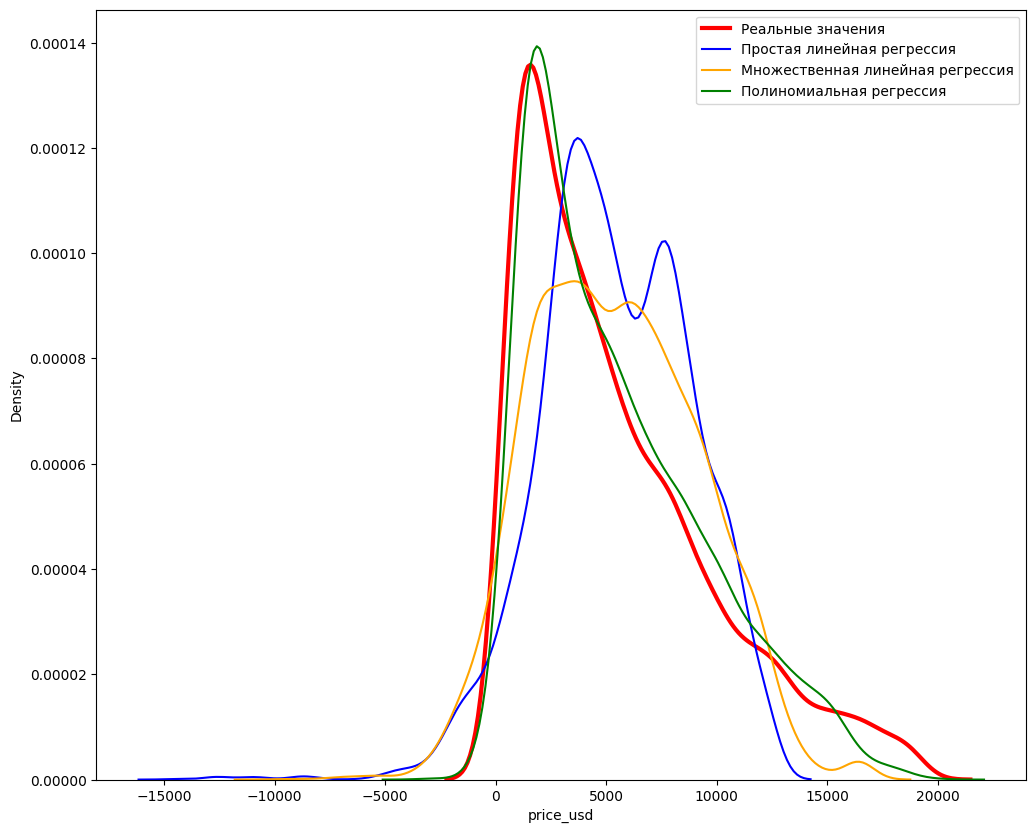

In [ ]:
plt.figure(figsize=(12,10))
sns.kdeplot(y_test, color='Red', label='Реальные значения', linewidth=3)
sns.kdeplot(best_slr_model.predict(X_slr_test), color='Blue', label='Простая линейная регрессия')
sns.kdeplot(best_lr_model.predict(X_test), color='Orange', label='Множественная линейная регрессия')
sns.kdeplot(best_pr_model.predict(X_test), color='Green', label='Полиномиальная регрессия')
plt.legend()
plt.show()

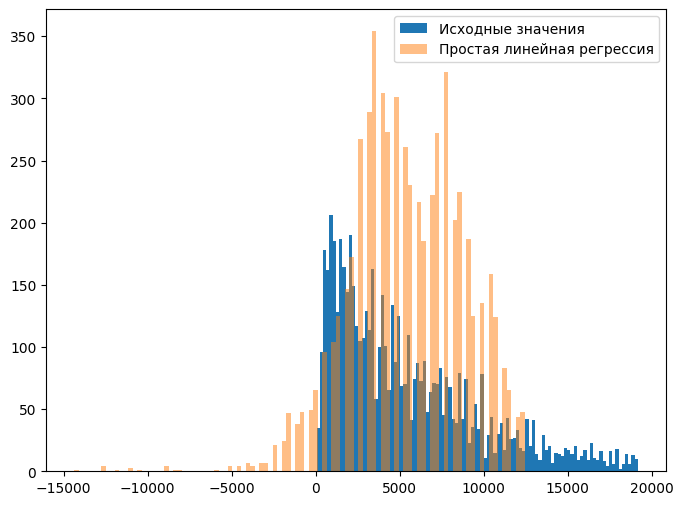

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=100, label='Исходные значения')
plt.hist(best_slr_model.predict(X_slr_test), bins=100, alpha = 0.5, label='Простая линейная регрессия')
plt.legend()
plt.show()

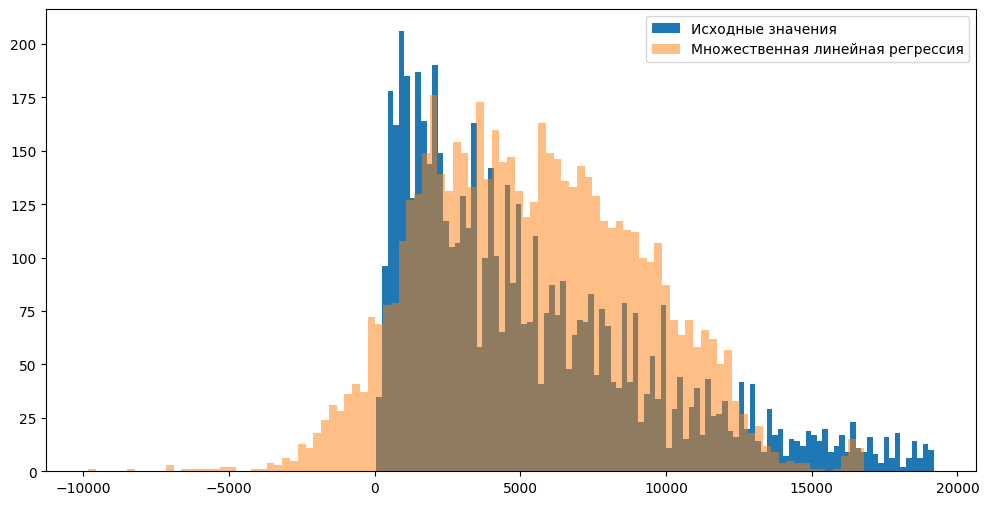

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(y_test, bins=100, label='Исходные значения')
plt.hist(best_lr_model.predict(X_test), bins=100, alpha = 0.5, label='Множественная линейная регрессия')
plt.legend()
plt.show()

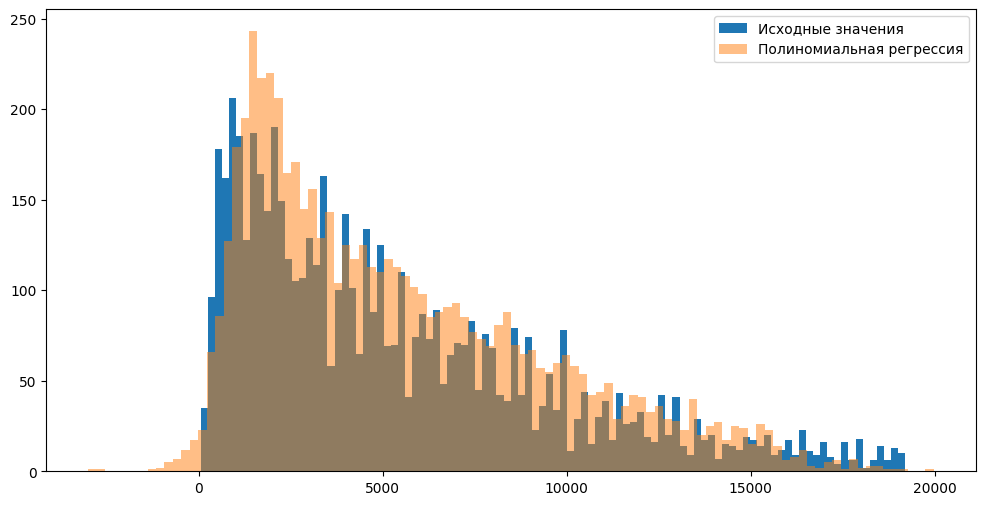

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(y_test, bins=100, label='Исходные значения')
plt.hist(best_pr_model.predict(X_test), bins=100, alpha=0.5, label='Полиномиальная регрессия')
plt.legend()
plt.show()

In [87]:
estimators = [[best_slr_model, X_slr_train, X_slr_test], [best_lr_model, X_train, X_test], [best_pr_model, X_train, X_test]]
estimator_names = ['Простая линейная регрессия', 'Множественная линейная регрессия', 'Полиномиальная регрессия']

table_train = pd.DataFrame()
for i in range(len(estimators)):
    y_pred = estimators[i][0].predict(estimators[i][1])
    table_train.loc[estimator_names[i], 'sklearn_MAE'] = round(mean_absolute_error(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'custom_MAE'] = round(quality_metrics.MAE(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'sklearn_MSE'] = str(round(mean_squared_error(y_train, y_pred), 4))
    table_train.loc[estimator_names[i], 'custom_MSE'] = str(round(quality_metrics.MSE(y_train, y_pred), 4))
    table_train.loc[estimator_names[i], 'sklearn_RMSE'] = round(sqrt(mean_squared_error(y_train, y_pred)), 4)
    table_train.loc[estimator_names[i], 'custom_RMSE'] = round(quality_metrics.RMSE(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'sklearn_MAPE'] = round(mean_absolute_percentage_error(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'custom_MAPE(%)'] = round(quality_metrics.MAPE(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'custom_SMAPE(%)'] = round(quality_metrics.SMAPE(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'sklearn_R2'] = round(estimators[i][0].score(estimators[i][1], y_train), 2)
    table_train.loc[estimator_names[i], 'custom_R2'] = round(quality_metrics.R2(y_train, y_pred), 2)
table_train

,sklearn_MAE,custom_MAE,sklearn_MSE,custom_MSE,sklearn_RMSE,custom_RMSE,sklearn_MAPE,custom_MAPE(%),custom_SMAPE(%),sklearn_R2,custom_R2
Простая линейная регрессия,1959.0913,1959.0913,6844909.2276,6844909.2276,2616.2777,2616.2777,1.2685,126.8548,36.3957,0.62,0.62
Множественная линейная регрессия,1519.6074,1519.6074,4249168.8907,4249168.8907,2061.3512,2061.3512,1.0222,102.2238,30.6540,0.76,0.76
Полиномиальная регрессия,1093.1207,1093.1207,2380008.1005,2380008.1005,1542.7275,1542.7275,0.6699,66.9923,20.5210,0.87,0.87


In [88]:
table_test = pd.DataFrame()
for i in range(len(estimators)):
    y_pred = estimators[i][0].predict(estimators[i][2])
    table_test.loc[estimator_names[i], 'sklearn_MAE'] = round(mean_absolute_error(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'custom_MAE'] = round(quality_metrics.MAE(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'sklearn_MSE'] = str(round(mean_squared_error(y_test, y_pred), 4))
    table_test.loc[estimator_names[i], 'custom_MSE'] = str(round(quality_metrics.MSE(y_test, y_pred), 4))
    table_test.loc[estimator_names[i], 'sklearn_RMSE'] = round(sqrt(mean_squared_error(y_test, y_pred)), 4)
    table_test.loc[estimator_names[i], 'custom_RMSE'] = round(quality_metrics.RMSE(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'sklearn_MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'custom_MAPE(%)'] = round(quality_metrics.MAPE(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'custom_SMAPE(%)'] = round(quality_metrics.SMAPE(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'sklearn_R2'] = round(estimators[i][0].score(estimators[i][2], y_test), 2)
    table_test.loc[estimator_names[i], 'custom_R2'] = round(quality_metrics.R2(y_test, y_pred), 2)
table_test

,sklearn_MAE,custom_MAE,sklearn_MSE,custom_MSE,sklearn_RMSE,custom_RMSE,sklearn_MAPE,custom_MAPE(%),custom_SMAPE(%),sklearn_R2,custom_R2
Простая линейная регрессия,1988.7845,1988.7845,7280325.8783,7280325.8783,2698.2079,2698.2079,0.8104,81.0401,35.9535,0.61,0.61
Множественная линейная регрессия,1558.4661,1558.4661,4593970.3274,4593970.3274,2143.3549,2143.3549,0.6259,62.5875,30.8088,0.75,0.75
Полиномиальная регрессия,1125.0184,1125.0184,2562621.4845,2562621.4845,1600.8190,1600.8190,0.3834,38.3407,20.6249,0.86,0.86


<font size = 6>
    <b>Вывод  </b>  
</font>

<font size = 4>

По результатам сравнения метрик качества различных моделей лучшей моделью оказалась полиномиальная регрессия, после неё идёт множественная линейная регрессия и самые неточные прогнозы выходят у простой линейной регрессии.  

<b>Метрика MAE:</b>  
* Простая линейная регрессия: 1959.0913 на тренировочных данных и 1988.7845 на тестовых
* Множественная линейная регрессия: 1519.6074 на тренировочных данных и 1558.4661 на тестовых
* Полиномиальная линейная регрессия: 1093.1207 на тренировочных данных и 1125.0184 на тестовых

<b>Метрика MSE:</b>  
* Простая линейная регрессия: 6844909.2276 на тренировочных данных и 7280325.8783 на тестовых
* Множественная линейная регрессия: 4249168.8907 на тренировочных данных и 4593970.3274 на тестовых
* Полиномиальная линейная регрессия: 2380008.1005 на тренировочных данных и 2562621.4845 на тестовых

<b>Метрика RMSE:</b>  
* Простая линейная регрессия: 2616.2777 на тренировочных данных и 2698.2079 на тестовых
* Множественная линейная регрессия: 2061.3512 на тренировочных данных и 2143.3549 на тестовых
* Полиномиальная линейная регрессия: 1542.7275 на тренировочных данных и 1600.8190 на тестовых

<b>Метрика MAPE:</b>  
* Простая линейная регрессия: 1.2685 на тренировочных данных и 0.8104 на тестовых
* Множественная линейная регрессия: 1.0222 на тренировочных данных и 0.6259 на тестовых
* Полиномиальная линейная регрессия: 0.6699 на тренировочных данных и 0.3834 на тестовых

Для всех представленных выше метрик самые наименьшие значения ошибок у полиномиальной регрессии, самые большие - у простой регрессии, что подтверждает, что полиномиальная регрессия работает точнее всех остальных, а простая линейная регрессия - самая неточная.

<b>Метрика R^2:</b>  
* Простая линейная регрессия: 0.62 на тренировочных данных и 0.61 на тестовых
* Множественная линейная регрессия: 0.76 на тренировочных данных и 0.75 на тестовых
* Полиномиальная линейная регрессия: 0.87 на тренировочных данных и 0.86 на тестовых

Вычисленные коэффициенты детермианции для разных моделей ещё раз показывают, что полиномиальная регрессия способна предсказывать данные лучше остальных, так как коэффициент детерминации у неё наибольший.  

Результаты метрик для тренировочных и тестовых данных примерно совпадают, что позволяет говорить, что модель не была переобучена
</font>